# Feature Crosses
**Suggested time to spend on exercise**: 24 minutes

Continuing on the previous exercise, we will improve our linear regression model with the addition of more synthetic features.

First, let's define the input and create the data loading code.

In [0]:
#@test {"output": "ignore"}

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.google as tf
from IPython import display
from google3.pyglib import gfile
from sklearn import metrics

def preprocess_features(california_housing_dataframe):
  """This function takes an input dataframe and returns a version of it that has
  various features selected and pre-processed.  The input dataframe contains
  data from the california_housing data set."""
  # Select fewer columns to allow training a bit faster.
  output_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housingMedianAge",
     "households",
     "medianIncome"]].copy()
  output_features["roomsPerPerson"] = (
    california_housing_dataframe["totalRooms"] /
    california_housing_dataframe["population"])
  return output_features


def preprocess_targets(california_housing_dataframe):
  """This function selects and potentially transforms the output target from
  an input dataframe containing data from the california_housing data set.
  The object returned is a pandas Series."""
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["medianHouseValue"] = (
    california_housing_dataframe["medianHouseValue"] / 1000.0)
  return output_targets


# Set the output display to have one digit for decimal places, for display
# readability only.
pd.options.display.float_format = "{:.1f}".format

# Load in the raw data.  Note that there's a separate test data set that we
# will leave untouched for now.
raw_training_df = pd.read_csv(
  gfile.Open("/placer/prod/home/ami/mlcc/california_housing/v1/train.csv"),
  sep=",")
# Randomize the data before selecting train / validation splits.
raw_training_df = raw_training_df.reindex(np.random.permutation(
  raw_training_df.index))

# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(raw_training_df.head(12000))
training_targets = preprocess_targets(raw_training_df.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(raw_training_df.tail(5000))
validation_targets = preprocess_targets(raw_training_df.tail(5000))

# Sanity check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housingMedianAge,households,medianIncome,roomsPerPerson
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.5,502.9,3.9,2.0
std,2.1,2.0,12.5,389.1,1.9,1.1
min,32.5,-124.3,1.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,607.0,4.7,2.3
max,42.0,-114.3,52.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housingMedianAge,households,medianIncome,roomsPerPerson
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,497.2,3.9,2.0
std,2.1,2.0,12.7,373.4,1.9,1.2
min,32.5,-124.3,1.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,278.0,2.6,1.5
50%,34.2,-118.5,29.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,599.0,4.8,2.3
max,41.9,-114.5,52.0,5189.0,15.0,55.2


Training targets summary:


,medianHouseValue
count,12000.0
mean,206.6
std,116.0
min,15.0
25%,118.8
50%,180.0
75%,263.8
max,500.0


Validation targets summary:


,medianHouseValue
count,5000.0
mean,208.9
std,116.0
min,15.0
25%,122.1
50%,181.3
75%,267.2
max,500.0


### Feature engineering

Creating relevant features greatly improves ML models, especially for simple models like regression. We learned in a previous exercise that two (or more) independent features often do not provide as much information as a feature derived from them.

We have already used a synthetic feature in our example: `roomsPerPerson`.

We can create simple synthetic features by performing operations on certain columns. However, this may become tedious for complex operations like bucketizing or crossing bucketized features. [Feature columns](http://cs/piper///depot/google3/third_party/tensorflow/contrib/layers/python/layers/feature_column.py) are powerful abstractions that make it easy to add synthetic features.

To use feature columns, you will need to define basic feature columns for all features. Run the cell below to define the feature columns for the input features.

In [0]:
longitude = tf.contrib.layers.real_valued_column("longitude")
latitude = tf.contrib.layers.real_valued_column("latitude")
housingMedianAge = tf.contrib.layers.real_valued_column("housingMedianAge")
households = tf.contrib.layers.real_valued_column("households")
medianIncome = tf.contrib.layers.real_valued_column("medianIncome")
roomsPerPerson = tf.contrib.layers.real_valued_column("roomsPerPerson")

feature_columns=set([
  longitude,
  latitude,
  housingMedianAge,
  households,
  medianIncome,
  roomsPerPerson])

### Using feature columns
To use feature columns, simply pass the `feature_columns` set to the constructor of the `LinearRegressor`. Note that internally, these always use feature columns - they are just determined automatically if you omit them.

One additional constraint is that you'll need to use the `input_fn` parameter of `fit()`, rather than the default `x` and `y` that we used thus far. This is for technical reasons, and will be simplified in the future. The `input_fn` parameter takes an input function, described below.

#### The input function

Previously, we passed data to the estimator using Pandas `DataFrame` objects. A more flexible, but more complex, way to pass data is through the input function.

One particularity of the estimators API is that input functions are responsible for splitting the data into batches, so the `batch_size` arg is ignored when using `input_fn`. The batch size will be determined by the number of rows that the input function returns (see below).

Input functions return [Tensor](https://www.tensorflow.org/versions/r0.8/api_docs/python/framework.html#Tensor) objects, which are the core data types used in TensorFlow. More specifically, input functions must return the following `(features, label)` tuple:
* `features`: A `dict` mapping `string` values (the feature name) to `Tensor` values of shape `(n, 1)` where `n` is the number of data rows (and therefore batch size) returned by the input function.
* `label`: A `Tensor` of shape `(n, 1)`, representing the corresponding labels.

As a side note, the input functions usually create a queue that reads the data sequentially (from a `SSTable` for instance), but this is an advanced topic not covered in this class.

For simplicity, our function will convert the entire `DataFrame` to a `Tensor`. This means we'll use a batch size of `17000` - somewhat on the large size, but that will work fine with our small model. This will make training somewhat slower, but thanks to vector optimizations the performance penalty won't be that bad.

Here's the necessary input function:

In [0]:
#@test {"output": "ignore"}

def _input_fn(examples_df, targets_df):
  # Converts a pair of examples/targets DataFrames to Tensors. The Tensors are
  # reshaped into (N,1) where N is number of examples in the DataFrames.
  # -1 is a special value to tf.reshape that means "replace me with whatever
  # size allows all the input values to fit into the output tensor."
  features = {}
  for column_name in examples_df.keys():
    features[column_name] = tf.to_float(
      tf.reshape(tf.constant(examples_df[column_name].values), [-1,1]))
  label_tensor = tf.to_float(
    tf.reshape(tf.constant(targets_df[targets_df.keys()[0]].values), [-1,1]))

  # Return a dict of feature Tensors and label Tensor.
  return features, label_tensor


For an example, the code below shows the output of the input function when passed a few sample records from the California housing data set.

In [0]:
#@test {"output": "ignore"}

# This snippet is for illustrative purposes only - it is not required for
# training the model.

training_examples_sample = training_examples.head(3)[["latitude", "longitude"]]
training_targets_sample = training_targets.head(3)

print "Sample features as DataFrame:"
print training_examples_sample

print "\nSample targets as DataFrame:"
print training_targets_sample

# Call the input function to see how it converts the data to Tensors
input_data = _input_fn(training_examples_sample, training_targets_sample)

print "\nSample features as dict of Tensors:"
print input_data[0]

print "\nSample targets as Tensor:"
print input_data[1]

# Create a TensorFlow session to evaluate and print our sample Tensors.
with tf.Session() as sess:
  print "\nValues in the Tensor for the longitude feature:"
  longitude_values = sess.run(input_data[0]['longitude'])
  print longitude_values

Sample features as DataFrame:
       latitude  longitude
6751       33.9     -118.3
16845      39.4     -123.4
10553      34.7     -120.4

Sample targets as DataFrame:
       medianHouseValue
6751              184.1
16845              96.0
10553             142.4

Sample features as dict of Tensors:
{'latitude': <tf.Tensor 'ToFloat:0' shape=(3, 1) dtype=float32>, 'longitude': <tf.Tensor 'ToFloat_1:0' shape=(3, 1) dtype=float32>}

Sample targets as Tensor:
Tensor("ToFloat_2:0", shape=(3, 1), dtype=float32)

Values in the Tensor for the longitude feature:
[[-118.29000092]
 [-123.37000275]
 [-120.44000244]]


### FTRL optimization algorithm

High dimensional linear models benefit from using a variant of gradient-based optimization called FTRL. This algorithm has the benefit of scaling the learning rate differently for different coefficients, which can be useful if some features rarely take non-zero values (it also is well suited to support L1 regularization, which will be discussed later in the course). We can apply FTRL using the [FtrlOptimizer](https://cs.corp.google.com/search/?q=symbol:FtrlOptimizer+f:ftrl.py$+package:piper).

Training model...
RMSE (on training data):
  period 00 : 105.19
  period 01 : 115.90
  period 02 : 112.23
  period 03 : 109.80
  period 04 : 107.78
  period 05 : 105.86
  period 06 : 103.87
  period 07 : 101.78
  period 08 : 99.66
  period 09 : 97.61
Final RMSE (on training data): 97.61
Final RMSE (on validation data): 98.39


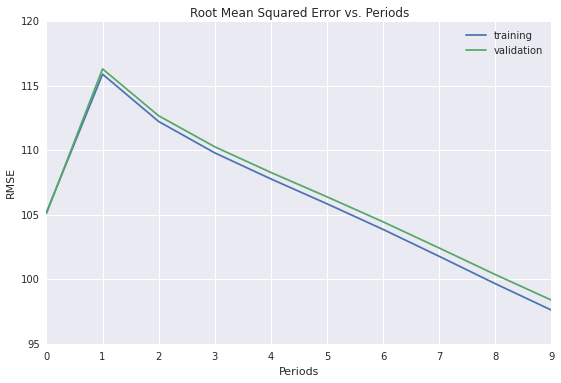

In [0]:
#@test {"output": "ignore", "timeout": 180}

LEARNING_RATE = 1.0  #@param
STEPS = 500  #@param
# No batch size - train expects input_fn to batch the data, but
# here we'll just train on the full set for simplicity.
periods = 10
steps_per_period = STEPS / periods

# Build a linear regression model, making sure we pass
# our explicit list of feature columns.
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=feature_columns,
  optimizer=tf.FtrlOptimizer(LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Train and evaluate the model.
training_losses = []
validation_losses = []
print("Training model...")
print("RMSE (on training data):")
training_rmse = []
validation_rmse = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    input_fn=lambda: _input_fn(training_examples, training_targets),
    steps=steps_per_period
  )
  training_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(training_examples, training_targets))
  validation_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(validation_examples, validation_targets))
  training_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(training_predictions, training_targets))
  validation_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(validation_predictions, validation_targets))
  print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
  training_rmse.append(training_root_mean_squared_error)
  validation_rmse.append(validation_root_mean_squared_error)

plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
plt.plot(training_rmse, label="training")
plt.plot(validation_rmse, label="validation")
plt.legend()

print("Final RMSE (on training data): %0.2f" % (
  training_root_mean_squared_error))
print("Final RMSE (on validation data): %0.2f" % (
  validation_root_mean_squared_error))

### Bucketized (binned) features

Bucketization is also known as binning.

We can bucketize `population` into the following 3 buckets (for instance):
- `Bucket[0]` (`< 5000`): corresponding to less populated blocks
- `Bucket[1]` (`5000 - 25000`): corresponding to mid populated blocks
- `Bucket[2]` (`> 25000`): corresponding to highly populated blocks

Given the preceding bucket definitions, the following `population` vector:

    [[10001], [42004], [2500], [18000]]

becomes the following bucketized feature vector:

    [[1], [2], [0], [1]]

The feature values are now the bucket indices.

To define bucketized features, use `bucketized_column`.

In [0]:
#@test {"output": "ignore"}

def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in xrange(num_buckets)])
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 7 buckets.
bucketized_households = tf.contrib.layers.bucketized_column(
  households, boundaries=get_quantile_based_buckets(
    training_examples["households"], 7))

# Divide longitude into 10 buckets.
bucketized_longitude = tf.contrib.layers.bucketized_column(
  longitude, boundaries=get_quantile_based_buckets(
    training_examples["longitude"], 10))

### Task 1: Train the model on bucketized feature columns.
**Bucketize all the real valued features in our example, train the model and see if the results improve.**

In the following code block, two real valued columns (namely `households` and `longitude`) have been transformed into bucketized feature columns. Your task is to bucketize the rest of the columns, then run the code to train the model. There are various heuristics to find the range of the buckets. This exercise uses a quantile-based technique, which chooses the bucket boundaries in such a way that each bucket has the same number of examples.

Feel free to copy and modify the code above.

In [0]:
#@test {"skip": true}

#
# Your code here: similarly bucketize the following columns.
#
bucketized_latitude = tf.contrib.layers.bucketized_column(
  latitude, boundaries=get_quantile_based_buckets(
    training_examples["latitude"], 10))
bucketized_housingMedianAge = tf.contrib.layers.bucketized_column(
  housingMedianAge, boundaries=get_quantile_based_buckets(
    training_examples["housingMedianAge"], 10))
bucketized_medianIncome = tf.contrib.layers.bucketized_column(
  medianIncome, boundaries=get_quantile_based_buckets(
    training_examples["medianIncome"], 10))
bucketized_roomsPerPerson = tf.contrib.layers.bucketized_column(
  roomsPerPerson, boundaries=get_quantile_based_buckets(
    training_examples["roomsPerPerson"], 10))

bucketized_feature_columns=set([
  bucketized_longitude,
  bucketized_latitude,
  bucketized_housingMedianAge,
  bucketized_households,
  bucketized_medianIncome,
  bucketized_roomsPerPerson])

# The remainder of the code retrains the model.

LEARNING_RATE = 0.01  #@param
STEPS = 50000  #@param
periods = 10
steps_per_period = STEPS / periods

# Build a linear regression model, making sure we pass
# our explicit list of feature columns.
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=bucketized_feature_columns,
  optimizer=tf.FtrlOptimizer(LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Train and evaluate the model.
training_losses = []
validation_losses = []
print("Training model...")
print("RMSE (on training data):")
training_rmse = []
validation_rmse = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    input_fn=lambda: _input_fn(training_examples, training_targets),
    steps=steps_per_period
  )
  training_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(training_examples, training_targets))
  validation_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(validation_examples, validation_targets))
  training_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(training_predictions, training_targets))
  validation_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(validation_predictions, validation_targets))
  print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
  training_rmse.append(training_root_mean_squared_error)
  validation_rmse.append(validation_root_mean_squared_error)

plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
plt.plot(training_rmse, label="training")
plt.plot(validation_rmse, label="validation")
plt.legend()

print("Final RMSE (on training data): %0.2f" % (
  training_root_mean_squared_error))
print("Final RMSE (on validation data): %0.2f" % (
  validation_root_mean_squared_error))

Training model...
RMSE (on training data):
  period 00 : 216.71
  period 01 : 208.51
  period 02 : 202.35


KeyboardInterrupt: ignored

Training model...
RMSE (on training data):
  period 00 : 137.93
  period 01 : 108.31
  period 02 : 93.04
  period 03 : 84.05
  period 04 : 78.43
  period 05 : 74.71
  period 06 : 72.11
  period 07 : 70.23
  period 08 : 68.85
  period 09 : 67.82
Final RMSE (on training data): 67.82
Final RMSE (on validation data): 68.82


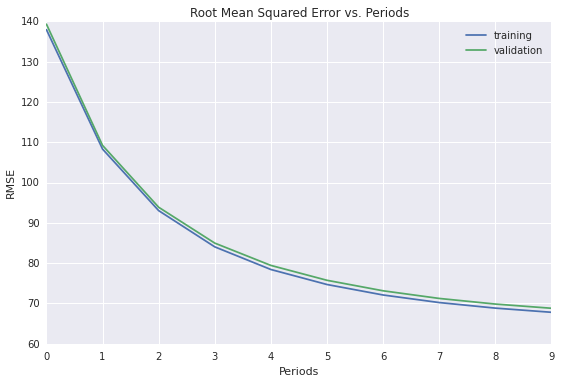

In [0]:
#@title To view a possible solution, toggle Form.

#@test {"output": "ignore", "timeout": 360}

#
# Solution: Use the above example to bucketize the remaining columns.
#
bucketized_latitude = tf.contrib.layers.bucketized_column(
  latitude, boundaries=get_quantile_based_buckets(
    training_examples["latitude"], 10))
bucketized_housingMedianAge = tf.contrib.layers.bucketized_column(
  housingMedianAge, boundaries=get_quantile_based_buckets(
    training_examples["housingMedianAge"], 7))
bucketized_medianIncome = tf.contrib.layers.bucketized_column(
  medianIncome, boundaries=get_quantile_based_buckets(
    training_examples["medianIncome"], 7))
bucketized_roomsPerPerson = tf.contrib.layers.bucketized_column(
  roomsPerPerson, boundaries=get_quantile_based_buckets(
    training_examples["roomsPerPerson"], 7))

bucketized_feature_columns = set([
  bucketized_longitude,
  bucketized_latitude,
  bucketized_housingMedianAge,
  bucketized_households,
  bucketized_medianIncome,
  bucketized_roomsPerPerson])

LEARNING_RATE = 1.5
STEPS = 500
periods = 10
steps_per_period = STEPS / periods

# Build a linear regression model, making sure we pass
# our explicit list of feature columns.
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=bucketized_feature_columns,
  optimizer=tf.FtrlOptimizer(LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Train and evaluate the model.
training_losses = []
validation_losses = []
print("Training model...")
print("RMSE (on training data):")
training_rmse = []
validation_rmse = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    input_fn=lambda: _input_fn(training_examples, training_targets),
    steps=steps_per_period
  )
  training_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(training_examples, training_targets))
  validation_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(validation_examples, validation_targets))
  training_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(training_predictions, training_targets))
  validation_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(validation_predictions, validation_targets))
  print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
  training_rmse.append(training_root_mean_squared_error)
  validation_rmse.append(validation_root_mean_squared_error)

plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
plt.plot(training_rmse, label="training")
plt.plot(validation_rmse, label="validation")
plt.legend()

print("Final RMSE (on training data): %0.2f" % (
  training_root_mean_squared_error))
print("Final RMSE (on validation data): %0.2f" % (
  validation_root_mean_squared_error))

### One-hot encoding for discrete features

Discrete features (i.e. categorical features) are usually converted into families of binary features before training a logistic regression model.

For example, suppose we have 3 training points (after bucketizing the real valued features):

1. $\mathbf{x_1}$ = `["longitude:{-120,-119}", "latitude:{35,36}"]`
1. $\mathbf{x_2}$ = `["longitude:{-115,-114}", "latitude:{38,39}"]`
1. $\mathbf{x_3}$ = `["longitude:{-120,-119}", "latitude:{40,41}"]`

where values in the brackets are the bucket ranges.

For each possible categorical value, we make a new **binary** feature whose value is 1 if the example has that value, and 0 if not. In the example above, the two categorical features would be converted into five binary features with names like `"longitude:{-120,-119}"`, and the training points now look like:

$$
\begin{pmatrix}
   & \texttt{longitude:\{-120,-119\}} & \texttt{longitude:\{-115,-114\}} & \texttt{latitude:\{35,36\}} & \texttt{latitude:\{38,39\}} & \texttt{latitude:\{40,41\}} \\
   \mathbf{x_1} =[ & 1 & 0 & 1 & 0 & 0 & ] \\
   \mathbf{x_2} =[ & 0 & 1 & 0 & 1 & 0 & ] \\
   \mathbf{x_3} =[ & 1 & 0 & 0 & 0 & 1 & ]
 \end{pmatrix}
$$

The key point is that when we train the model, we'll determine separate weights for each of the new binary features. In this example we say that `longitude` is a **feature column** containing the features `longitude:{-120,-119}` and `longitude:{-115,-114}`.

### Feature crosses

Crossing two (or more) features is a clever way to learn non-linear relations using a linear model. In our problem, if we just use the feature `latitude` for learning, the model might learn that city blocks at a particular latitude (or within a particular range of latitudes since we have bucketized it) are more likely to be expensive than others. Similarly for the feature `longitude`. However, if we cross `longitude` by `latitude`, the crossed feature represents a well defined city block. If the model learns that certain city blocks (within range of latitudes and longitudes) are more likely to be more expensive than others, it is a stronger signal than two features considered individually.

If we cross the `latitude` and `longitude` features (supposing, as above, that `longitude` has only 2 values, while `latitude` has only 3 values), we actually get six crossed binary features: `longitude:{-120,-119}_X_latitude:{35,36}`, `longitude:{-120,-119}_X_latitude:{38,39}`, etc. The feature `longitude:{-120,-119}_X_latitude:{35,36}`, for example, is the product of `longitude:{-120,-119}` and `latitude:{35,36}`, which means that it's a binary feature which has value 1 when the example has a longitude between `(-120,-119)` and a latitude between `(35,36)`.

Again, each of these features will get its own separate weight when we train the model.

### Task 2: Train the model using feature crosses.

**Add a feature cross of `longitude` and `latitude` to your model, train it, and determine whether the results improve.**

In [0]:
#@test {"skip": true}

# Note: crossed_column only supports discrete columns, so both latitude and
# longitude must be bucketized.
# But, crossing real columns is possible as well - you just multiply them.
long_x_lat = tf.contrib.layers.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

#
# Your code here: Create a feature column set that includes the cross.
#
feature_columns_with_cross = 

# The remainder of the code retrains the model.

LEARNING_RATE = 1.0  #@param
STEPS = 500  #@param
periods = 10
steps_per_period = STEPS / periods

# Build a linear regression model, making sure we pass
# our explicit list of feature columns.
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=feature_columns_with_cross,
  optimizer=tf.FtrlOptimizer(LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Train and evaluate the model.
training_losses = []
validation_losses = []
print("Training model...")
print("RMSE (on training data):")
training_rmse = []
validation_rmse = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    input_fn=lambda: _input_fn(training_examples, training_targets),
    steps=steps_per_period
  )
  training_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(training_examples, training_targets))
  validation_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(validation_examples, validation_targets))
  training_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(training_predictions, training_targets))
  validation_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(validation_predictions, validation_targets))
  print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
  training_rmse.append(training_root_mean_squared_error)
  validation_rmse.append(validation_root_mean_squared_error)

plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
plt.plot(training_rmse, label="training")
plt.plot(validation_rmse, label="validation")
plt.legend()

print("Final RMSE (on training data): %0.2f" % (
  training_root_mean_squared_error))
print("Final RMSE (on validation data): %0.2f" % (
  validation_root_mean_squared_error))

Training model...
RMSE (on training data):
  period 00 : 77.57
  period 01 : 60.73
  period 02 : 57.55
  period 03 : 57.29
  period 04 : 57.24
  period 05 : 57.21
  period 06 : 57.20
  period 07 : 57.19
  period 08 : 57.18
  period 09 : 57.17
Final RMSE (on training data): 57.17
Final RMSE (on validation data): 58.57


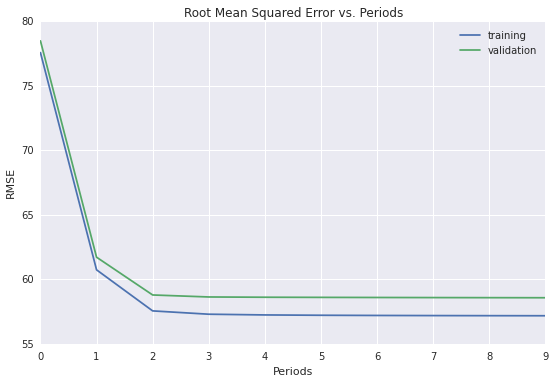

In [0]:
#@title To view a possible solution, toggle Form.

#@test {"output": "ignore", "timeout": 360}

long_x_lat = tf.contrib.layers.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000)

#
# Solution: just include the new column in our list! Let's keep the bucketized
# columns as well.
#
feature_columns_with_cross = set([
  long_x_lat,
  bucketized_longitude,
  bucketized_latitude,
  bucketized_housingMedianAge,
  bucketized_households,
  bucketized_medianIncome,
  bucketized_roomsPerPerson])

LEARNING_RATE = 3.0
STEPS = 500
periods = 10
steps_per_period = STEPS / periods

# Build a linear regression model, making sure we pass
# our explicit list of feature columns.
linear_regressor = tf.contrib.learn.LinearRegressor(
  feature_columns=feature_columns_with_cross,
  optimizer=tf.FtrlOptimizer(LEARNING_RATE),
  gradient_clip_norm=5.0
)

# Train and evaluate the model.
training_losses = []
validation_losses = []
print("Training model...")
print("RMSE (on training data):")
training_rmse = []
validation_rmse = []
for period in range (0, periods):
  # Train the model, starting from the prior state.
  linear_regressor.fit(
    input_fn=lambda: _input_fn(training_examples, training_targets),
    steps=steps_per_period
  )
  training_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(training_examples, training_targets))
  validation_predictions = linear_regressor.predict(
    input_fn=lambda: _input_fn(validation_examples, validation_targets))
  training_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(training_predictions, training_targets))
  validation_root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(validation_predictions, validation_targets))
  print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
  training_rmse.append(training_root_mean_squared_error)
  validation_rmse.append(validation_root_mean_squared_error)

plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.tight_layout()
plt.plot(training_rmse, label="training")
plt.plot(validation_rmse, label="validation")
plt.legend()

print("Final RMSE (on training data): %0.2f" % (
  training_root_mean_squared_error))
print("Final RMSE (on validation data): %0.2f" % (
  validation_root_mean_squared_error))

### Optional Challenge: Try out more synthetic features.

So far, we've tried simple bucketized columns and feature crosses, but there are many more combinations that could potentially improve the results. For example, you could cross multiple columns. What happens if you vary the number of buckets? What other synthetic features can you think of? Do they improve the model?